# COVID-19 Radiography Lung Segmentation

This notebook trains U-Net and U-Net++ on the Normal class masks from the COVID-19 Radiography Dataset and visualizes 10 samples with ground truth and predictions.

## Install dependencies

Install `opendatasets` to download datasets from Kaggle.


In [ ]:
!pip install opendatasets

## Download dataset

Download the COVID-19 Radiography Database from Kaggle. In Colab, upload `kaggle.json` to `/root/.kaggle/` first.


In [ ]:
import os
import opendatasets as op
op.download("https://www.kaggle.com/datasets/tawsifurrahman/covid19-radiography-database/")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: DKrzv
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/tawsifurrahman/covid19-radiography-database


100%|██████████| 778M/778M [00:06<00:00, 121MB/s] 


## Imports and paths

Import libraries, locate the folders with normal images and masks, and verify file counts.


In [ ]:
import glob, numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

tf.random.set_seed(42)
np.random.seed(42)

BASE = "covid19-radiography-database/COVID-19_Radiography_Dataset"

def resolve_image_dir():
    if os.path.isdir(os.path.join(BASE, "Normal", "images")):
        return os.path.join(BASE, "Normal", "images")
    return os.path.join(BASE, "Normal")

def resolve_mask_dir():
    if os.path.isdir(os.path.join(BASE, "Normal", "masks")):
        return os.path.join(BASE, "Normal", "masks")
    if os.path.isdir(os.path.join(BASE, "Normal_mask", "masks")):
        return os.path.join(BASE, "Normal_mask", "masks")
    return os.path.join(BASE, "Normal_mask")

IMG_DIR = resolve_image_dir()
MSK_DIR = resolve_mask_dir()

img_paths = sorted(glob.glob(os.path.join(IMG_DIR, "*.png")))
msk_paths = sorted(glob.glob(os.path.join(MSK_DIR, "*.png")))

print(f"Images: {len(img_paths)} | Masks: {len(msk_paths)}")
assert len(img_paths) == len(msk_paths), "Image/mask counts do not match."

Images: 10192 | Masks: 10192


## Data preparation

Set image size, build (image, mask) pairs, split into train/val/test, and create tf.data pipelines.


In [ ]:
IMG_SIZE = 256
BATCH_SIZE = 8
AUTOTUNE = tf.data.AUTOTUNE

def load_pair(img_path, msk_path):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_png(img, channels=1)
    img = tf.image.resize(img, (IMG_SIZE, IMG_SIZE))
    img = tf.cast(img, tf.float32) / 255.0

    msk = tf.io.read_file(msk_path)
    msk = tf.image.decode_png(msk, channels=1)
    msk = tf.image.resize(msk, (IMG_SIZE, IMG_SIZE))
    msk = tf.cast(msk, tf.float32) / 255.0
    msk = tf.where(msk > 0.5, 1.0, 0.0)
    return img, msk

train_imgs, test_imgs, train_msks, test_msks = train_test_split(
    img_paths, msk_paths, test_size=0.2, random_state=42
)
train_imgs, val_imgs, train_msks, val_msks = train_test_split(
    train_imgs, train_msks, test_size=0.2, random_state=42
)

def make_ds(imgs, msks, training=False):
    ds = tf.data.Dataset.from_tensor_slices((imgs, msks))
    if training:
        ds = ds.shuffle(512)
    ds = ds.map(load_pair, num_parallel_calls=AUTOTUNE)
    ds = ds.batch(BATCH_SIZE).prefetch(AUTOTUNE)
    return ds

train_ds = make_ds(train_imgs, train_msks, training=True)
val_ds = make_ds(val_imgs, val_msks)
test_ds = make_ds(test_imgs, test_msks)

## Metrics and U-Net

Define Dice metric and loss, build the U-Net architecture, and compile the model.


In [ ]:
def dice_coef(y_true, y_pred, smooth=1.0):
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    return (2.0 * intersection + smooth) / (
        tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth
    )

def dice_loss(y_true, y_pred):
    return 1.0 - dice_coef(y_true, y_pred)

def conv_block(x, filters):
    x = tf.keras.layers.Conv2D(filters, 3, padding="same")(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)
    x = tf.keras.layers.Conv2D(filters, 3, padding="same")(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)
    return x

def build_unet(input_shape=(IMG_SIZE, IMG_SIZE, 1), base_filters=32):
    inputs = tf.keras.Input(shape=input_shape)

    c1 = conv_block(inputs, base_filters)
    p1 = tf.keras.layers.MaxPooling2D()(c1)
    c2 = conv_block(p1, base_filters * 2)
    p2 = tf.keras.layers.MaxPooling2D()(c2)
    c3 = conv_block(p2, base_filters * 4)
    p3 = tf.keras.layers.MaxPooling2D()(c3)
    c4 = conv_block(p3, base_filters * 8)
    p4 = tf.keras.layers.MaxPooling2D()(c4)

    c5 = conv_block(p4, base_filters * 16)

    u4 = tf.keras.layers.UpSampling2D()(c5)
    u4 = tf.keras.layers.Concatenate()([u4, c4])
    c6 = conv_block(u4, base_filters * 8)

    u3 = tf.keras.layers.UpSampling2D()(c6)
    u3 = tf.keras.layers.Concatenate()([u3, c3])
    c7 = conv_block(u3, base_filters * 4)

    u2 = tf.keras.layers.UpSampling2D()(c7)
    u2 = tf.keras.layers.Concatenate()([u2, c2])
    c8 = conv_block(u2, base_filters * 2)

    u1 = tf.keras.layers.UpSampling2D()(c8)
    u1 = tf.keras.layers.Concatenate()([u1, c1])
    c9 = conv_block(u1, base_filters)

    outputs = tf.keras.layers.Conv2D(1, 1, activation="sigmoid")(c9)
    return tf.keras.Model(inputs, outputs)

unet = build_unet()
bce = tf.keras.losses.BinaryCrossentropy()
unet.compile(optimizer="adam", loss=lambda y_true, y_pred: bce(y_true, y_pred) + dice_loss(y_true, y_pred), metrics=[dice_coef])
unet.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 256, 256,  │        320 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 256, 256,  │        128 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu (ReLU)        │ (None, 256, 256,  │          0 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 256, 256,  │      9,248 │ re_lu[0][0]       │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │        128 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_1 (ReLU)      │ (None, 256, 256,  │          0 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 128, 128,  │          0 │ re_lu_1[0][0]     │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 128, 128,  │     18,496 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        256 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_2 (ReLU)      │ (None, 128, 128,  │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 128, 128,  │     36,928 │ re_lu_2[0][0]     │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        256 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_3 (ReLU)      │ (None, 128, 128,  │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 64, 64,    │          0 │ re_lu_3[0][0]     │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 64, 64,    │     73,856 │ max_pooling2d_1[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        512 │ conv2d_4[0][0]  

 Total params: 7,857,857 (29.98 MB)

 Trainable params: 7,851,969 (29.95 MB)

 Non-trainable params: 5,888 (23.00 KB)

## Train U-Net

Train U-Net on the training set and monitor validation performance.


In [ ]:
EPOCHS_UNET = 5
history_unet = unet.fit(train_ds, validation_data=val_ds, epochs=EPOCHS_UNET)

Epoch 1/5
816/816 ━━━━━━━━━━━━━━━━━━━━ 220s 218ms/step - dice_coef: 0.9048 - loss: 0.1820 - val_dice_coef: 0.8155 - val_loss: 0.5742
Epoch 2/5
816/816 ━━━━━━━━━━━━━━━━━━━━ 152s 187ms/step - dice_coef: 0.9820 - loss: 0.0380 - val_dice_coef: 0.9825 - val_loss: 0.0418
Epoch 3/5
816/816 ━━━━━━━━━━━━━━━━━━━━ 155s 190ms/step - dice_coef: 0.9870 - loss: 0.0270 - val_dice_coef: 0.8150 - val_loss: 0.9312
Epoch 4/5
816/816 ━━━━━━━━━━━━━━━━━━━━ 155s 190ms/step - dice_coef: 0.9866 - loss: 0.0278 - val_dice_coef: 0.9889 - val_loss: 0.0231
Epoch 5/5
816/816 ━━━━━━━━━━━━━━━━━━━━ 199s 186ms/step - dice_coef: 0.9894 - loss: 0.0218 - val_dice_coef: 0.9898 - val_loss: 0.0218


## U-Net visualization

Display 10 examples: original image, ground-truth mask, and U-Net prediction.


1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step


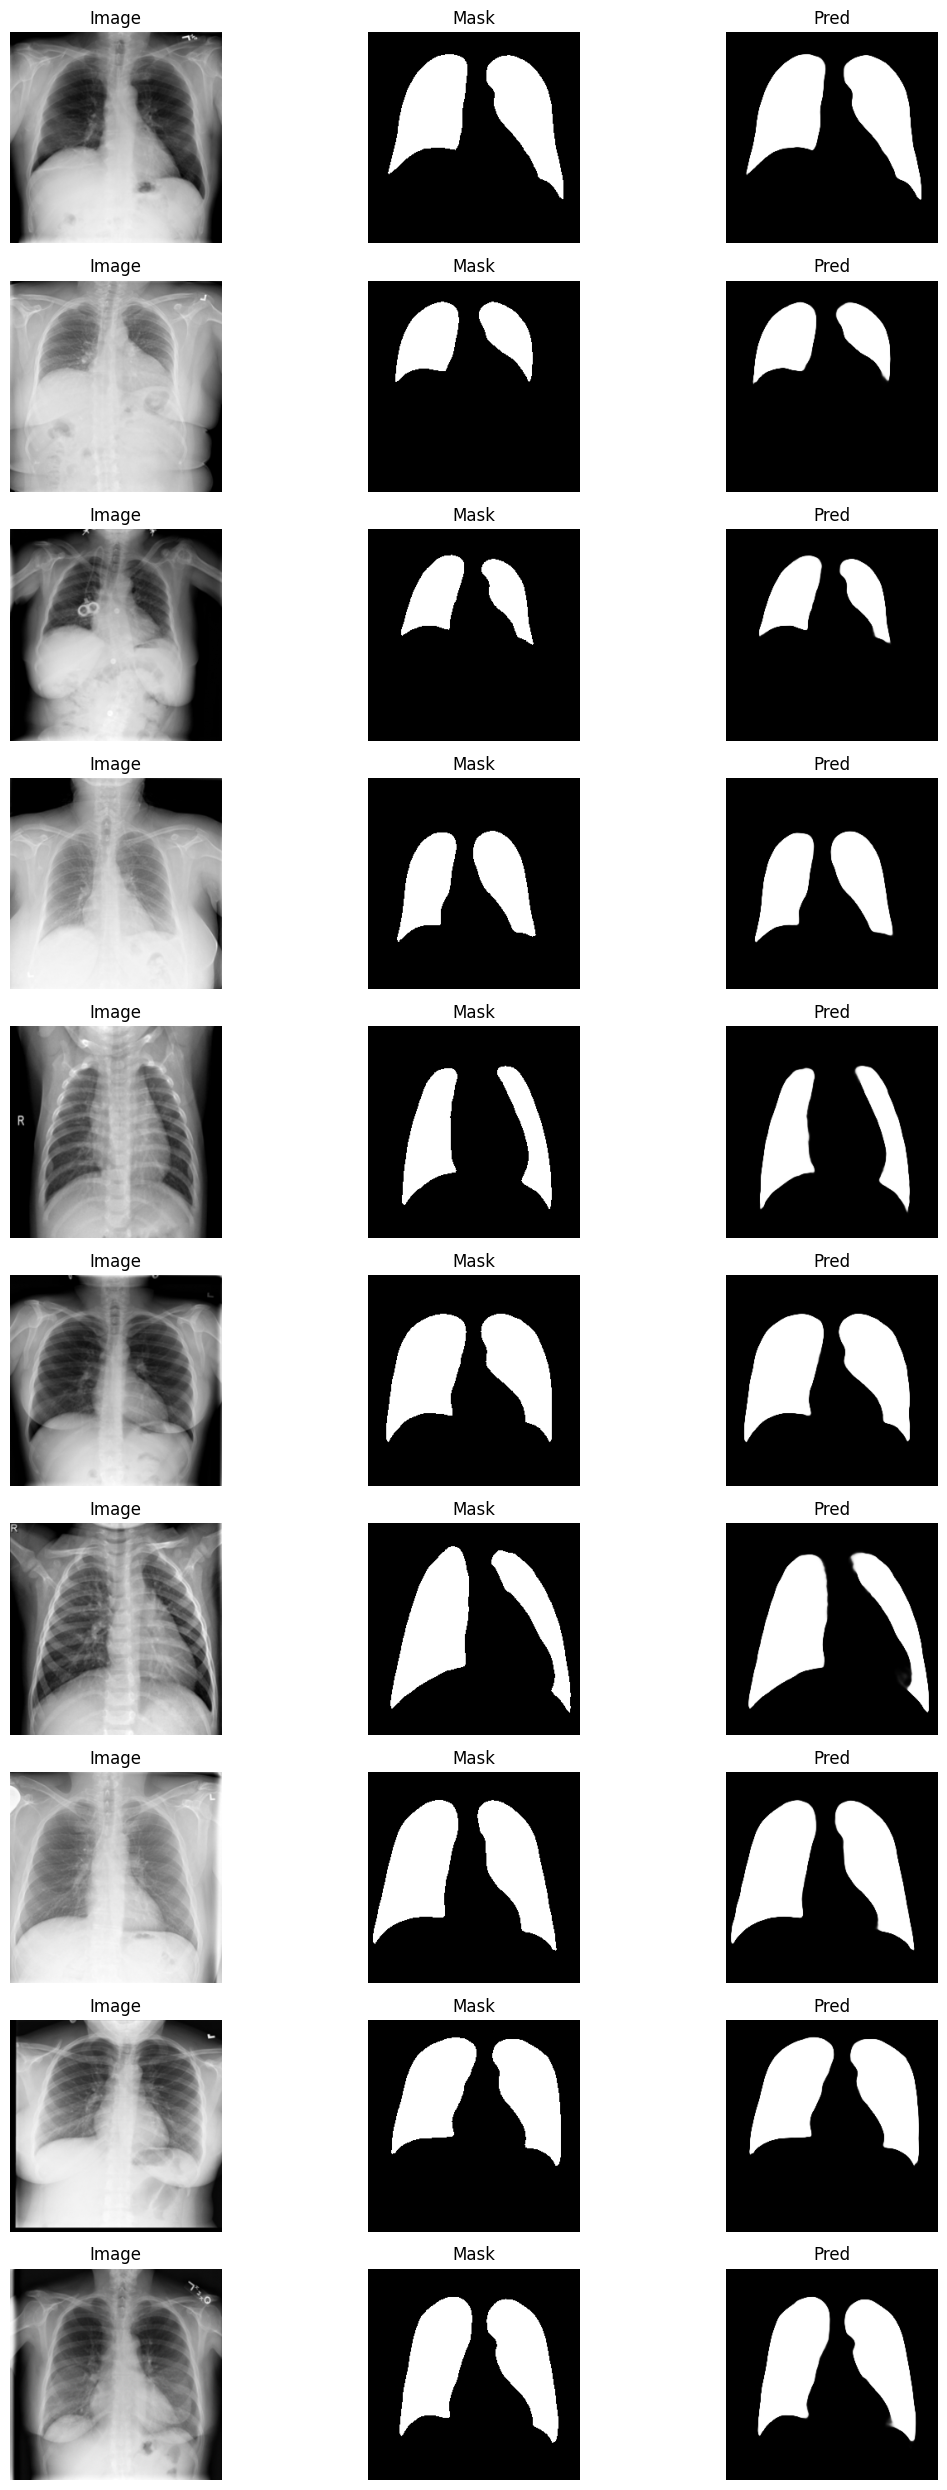

In [ ]:
def plot_triplets(images, masks, preds, n=10):
    plt.figure(figsize=(12, n * 2.5))
    for i in range(n):
        plt.subplot(n, 3, i * 3 + 1)
        plt.imshow(images[i, :, :, 0], cmap="gray")
        plt.title("Image")
        plt.axis("off")

        plt.subplot(n, 3, i * 3 + 2)
        plt.imshow(masks[i, :, :, 0], cmap="gray")
        plt.title("Mask")
        plt.axis("off")

        plt.subplot(n, 3, i * 3 + 3)
        plt.imshow(preds[i, :, :, 0], cmap="gray")
        plt.title("Pred")
        plt.axis("off")
    plt.tight_layout()
    plt.show()

sample_images, sample_masks = next(iter(test_ds.unbatch().batch(10)))
preds = unet.predict(sample_images)
plot_triplets(sample_images.numpy(), sample_masks.numpy(), preds, n=10)


## U-Net++

Build U-Net++ with nested skip connections and compile the model.


In [ ]:
def build_unetpp(input_shape=(IMG_SIZE, IMG_SIZE, 1), base_filters=32):
    inputs = tf.keras.Input(shape=input_shape)

    x00 = conv_block(inputs, base_filters)
    p0 = tf.keras.layers.MaxPooling2D()(x00)
    x10 = conv_block(p0, base_filters * 2)
    p1 = tf.keras.layers.MaxPooling2D()(x10)
    x20 = conv_block(p1, base_filters * 4)
    p2 = tf.keras.layers.MaxPooling2D()(x20)
    x30 = conv_block(p2, base_filters * 8)
    p3 = tf.keras.layers.MaxPooling2D()(x30)
    x40 = conv_block(p3, base_filters * 16)

    x01 = conv_block(tf.keras.layers.Concatenate()([x00, tf.keras.layers.UpSampling2D()(x10)]), base_filters)
    x11 = conv_block(tf.keras.layers.Concatenate()([x10, tf.keras.layers.UpSampling2D()(x20)]), base_filters * 2)
    x21 = conv_block(tf.keras.layers.Concatenate()([x20, tf.keras.layers.UpSampling2D()(x30)]), base_filters * 4)
    x31 = conv_block(tf.keras.layers.Concatenate()([x30, tf.keras.layers.UpSampling2D()(x40)]), base_filters * 8)

    x02 = conv_block(tf.keras.layers.Concatenate()([x00, x01, tf.keras.layers.UpSampling2D()(x11)]), base_filters)
    x12 = conv_block(tf.keras.layers.Concatenate()([x10, x11, tf.keras.layers.UpSampling2D()(x21)]), base_filters * 2)
    x22 = conv_block(tf.keras.layers.Concatenate()([x20, x21, tf.keras.layers.UpSampling2D()(x31)]), base_filters * 4)

    x03 = conv_block(tf.keras.layers.Concatenate()([x00, x01, x02, tf.keras.layers.UpSampling2D()(x12)]), base_filters)
    x13 = conv_block(tf.keras.layers.Concatenate()([x10, x11, x12, tf.keras.layers.UpSampling2D()(x22)]), base_filters * 2)

    x04 = conv_block(tf.keras.layers.Concatenate()([x00, x01, x02, x03, tf.keras.layers.UpSampling2D()(x13)]), base_filters)

    outputs = tf.keras.layers.Conv2D(1, 1, activation="sigmoid")(x04)
    return tf.keras.Model(inputs, outputs)

unetpp = build_unetpp()
unetpp.compile(optimizer="adam", loss=lambda y_true, y_pred: bce(y_true, y_pred) + dice_loss(y_true, y_pred), metrics=[dice_coef])
unetpp.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_19 (Conv2D)  │ (None, 256, 256,  │        320 │ input_layer_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │        128 │ conv2d_19[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_18 (ReLU)     │ (None, 256, 256,  │          0 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_20 (Conv2D)  │ (None, 256, 256,  │      9,248 │ re_lu_18[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │        128 │ conv2d_20[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_19 (ReLU)     │ (None, 256, 256,  │          0 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 128, 128,  │          0 │ re_lu_19[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_21 (Conv2D)  │ (None, 128, 128,  │     18,496 │ max_pooling2d_4[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        256 │ conv2d_21[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_20 (ReLU)     │ (None, 128, 128,  │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_22 (Conv2D)  │ (None, 128, 128,  │     36,928 │ re_lu_20[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        256 │ conv2d_22[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_21 (ReLU)     │ (None, 128, 128,  │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_5     │ (None, 64, 64,    │          0 │ re_lu_21[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_23 (Conv2D)  │ (None, 64, 64,    │     73,856 │ max_pooling2d_5[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        512 │ conv2d_23[0][0] 

 Total params: 9,170,049 (34.98 MB)

 Trainable params: 9,162,753 (34.95 MB)

 Non-trainable params: 7,296 (28.50 KB)

## Train U-Net++

Train U-Net++ on the same data.


In [ ]:
EPOCHS_UNETPP = 5
history_unetpp = unetpp.fit(train_ds, validation_data=val_ds, epochs=EPOCHS_UNETPP)

Epoch 1/5
816/816 ━━━━━━━━━━━━━━━━━━━━ 482s 517ms/step - dice_coef: 0.9020 - loss: 0.1855 - val_dice_coef: 0.9814 - val_loss: 0.0428
Epoch 2/5
816/816 ━━━━━━━━━━━━━━━━━━━━ 422s 470ms/step - dice_coef: 0.9844 - loss: 0.0322 - val_dice_coef: 0.9852 - val_loss: 0.0344
Epoch 3/5
816/816 ━━━━━━━━━━━━━━━━━━━━ 387s 475ms/step - dice_coef: 0.9875 - loss: 0.0260 - val_dice_coef: 0.9828 - val_loss: 0.0387
Epoch 4/5
816/816 ━━━━━━━━━━━━━━━━━━━━ 388s 475ms/step - dice_coef: 0.9890 - loss: 0.0226 - val_dice_coef: 0.9849 - val_loss: 0.0368
Epoch 5/5
816/816 ━━━━━━━━━━━━━━━━━━━━ 438s 470ms/step - dice_coef: 0.9899 - loss: 0.0210 - val_dice_coef: 0.9872 - val_loss: 0.0290


## U-Net++ visualization

Display 10 examples: original image, ground-truth mask, and U-Net++ prediction.


1/1 ━━━━━━━━━━━━━━━━━━━━ 13s 13s/step


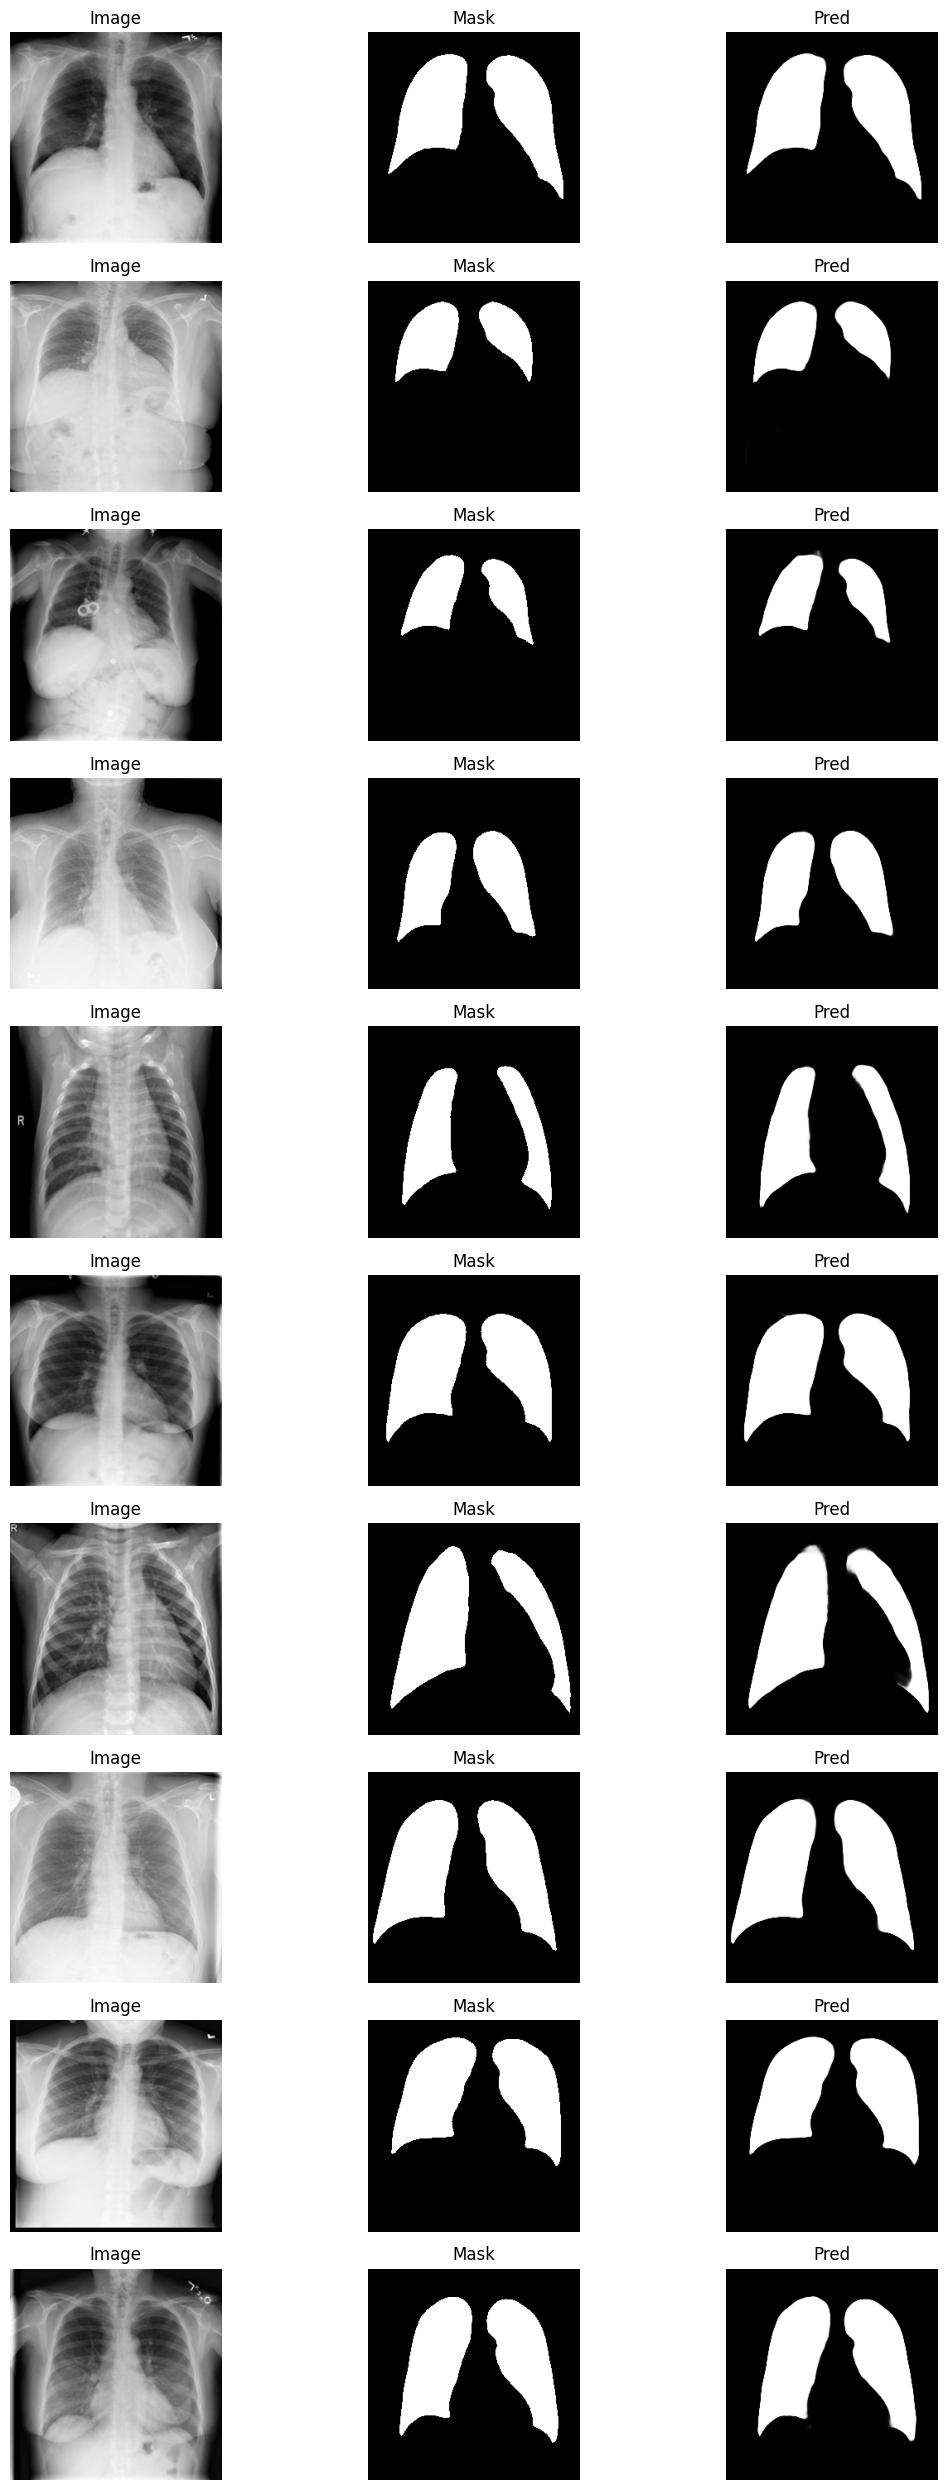

In [ ]:
sample_images, sample_masks = next(iter(test_ds.unbatch().batch(10)))
preds_pp = unetpp.predict(sample_images)
plot_triplets(sample_images.numpy(), sample_masks.numpy(), preds_pp, n=10)

## Experimental conclusion

Both architectures (U-Net and U-Net++) successfully segment lungs on normal chest X-rays. Visual comparison shows close overlap between predictions and ground-truth masks, indicating correct data preparation and training.

## Final conclusion

For lung segmentation on normal radiographs, both models achieve strong qualitative results. U-Net is simpler and computationally cheaper, while U-Net++ can potentially improve accuracy due to its more complex connectivity.
